## Lab: Gaussian Mixture Models

Motivation

In this lab, you will apply Gaussian Mixture Models (GMM) to the Breast Cancer Wisconsin Diagnostic dataset. Unlike K-Means, GMM uses probabilistic clustering, allowing for soft assignments rather than strict cluster boundaries. This makes it useful for identifying uncertainty in clustering, such as anomalies in data.

By completing the steps, you will:

* Prepare and scale the dataset.
* Determine the optimal number of clusters using BIC (Bayesian Information Criterion).
* Perform clustering using GMM and evaluate its quality using Silhouette Score.
* Identify potential anomalies based on cluster probabilities.
* Compare GMM with K-Means clustering.


This lab is auto-graded in CodeGrade, so follow the steps carefully.

### Step 0: Load and Prepare the Dataset (Provided)
The code for this step is already given. It performs the following:

* Imports necessary libraries, including GaussianMixture from sklearn.mixture.
* Loads the Breast Cancer dataset from sklearn.datasets.load_breast_cancer().
* Creates a DataFrame with feature data.
* Removes labels to simulate an unsupervised learning scenario.

No modifications are needed for this step.

In [1]:
# CodeGrade step0

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.datasets import load_breast_cancer


In [2]:
# CodeGrade step0

# Load dataset
cancer = load_breast_cancer()
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)

# Remove labels (unsupervised learning)
df_unlabeled = df.copy()


### Step 1: Rescale the Data
Objective: Standardize the dataset before applying GMM.

Instructions
* Use StandardScaler from sklearn.preprocessing to normalize all features.
* Fit the scaler to the dataset and transform it into a new variable called df_scaled.
* Ensure that df_scaled retains the same shape as the original data.

In [3]:
# CodeGrade step1

# Rescale
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_unlabeled), 
                         columns=df_unlabeled.columns)


# Shape
df_scaled.shape


(569, 30)

### Step 2: Determine the Optimal Number of Components (BIC & AIC)
Objective: Use Bayesian Information Criterion (BIC) and Akaike Information Criterion (AIC) to find the best number of clusters.

Instructions
* Initialize two empty lists: bic_scores and aic_scores.
* Loop over values of K from 1 to 9:
  * Train a GaussianMixture model with k components, random_state=42, and n_init=10.
  * Fit the model to df_scaled and store the BIC and AIC scores.
* Compute and return the difference between the sum of BIC scores and AIC scores, rounded to 0 decimal places.

In [4]:
# CodeGrade step2

# ic's for k
bic_scores = []
aic_scores = []
k_values = range(1, 11)
# for loop
for k in k_values:
    gmm = GaussianMixture(n_components=k, random_state=42, n_init=10)
    gmm.fit(df_scaled)
    bic_scores.append(gmm.bic(df_scaled))
    aic_scores.append(gmm.aic(df_scaled))

# Round sum of difference
round(sum(bic_scores) - sum(aic_scores), 0)

118458.0

Plot the BIC score to visualize the optimal K:
* X-axis: Number of Components (K).
* Y-axis: BIC Score.
* Use markers ('o') and a line ('-').

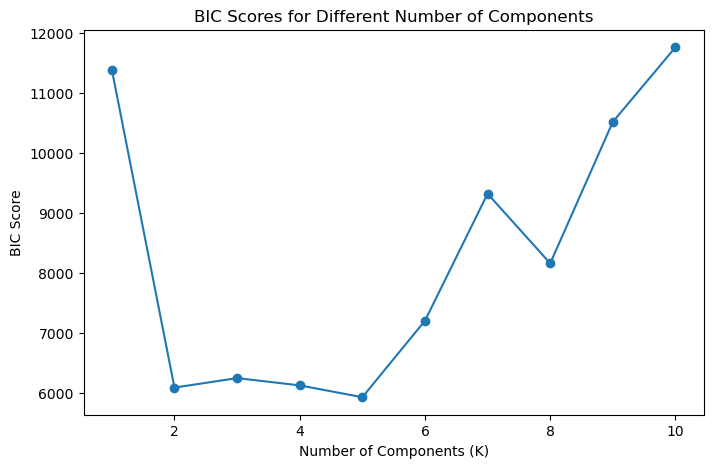

In [5]:
# Plot BIC to find optimal K
plt.figure(figsize=(8, 5))
plt.plot(k_values, bic_scores, marker='o', linestyle='-')
plt.xlabel("Number of Components (K)")
plt.ylabel("BIC Score")
plt.title("BIC Scores for Different Number of Components")
plt.show()

### Step 3: Perform GMM Clustering
Objective: Apply GMM clustering using the best K from Step 2.

Instructions
* Set optimal_k  (determined from BIC analysis).
* Train a GaussianMixture model with optimal_k, random_state=42, and n_init=10.
* Assign cluster labels to df_unlabeled["GMM_Cluster"].
* Compute and store maximum cluster probability for each sample in df_unlabeled["Cluster_Probability"].
* Compute the Silhouette Score and return it rounded to 4 decimal places.

In [6]:
# CodeGrade step3

# Optimal k
optimal_k =  k_values[int(np.argmin(bic_scores))]
gmm = GaussianMixture(n_components=optimal_k, random_state=42, n_init=10)
# fit the model
gmm.fit(df_scaled)

# Assign probabilities to each cluster
df_unlabeled["GMM_Cluster"] = gmm.predict(df_scaled)
df_unlabeled["Cluster_Probability"] = gmm.predict_proba(df_scaled).max(axis=1)

# Find and round the Silhouette Average
silhouette_avg = silhouette_score(df_scaled, df_unlabeled["GMM_Cluster"])

# round
round(silhouette_avg, 4)

0.1397

### Step 4: Identify Anomalies
Objective: Detect outliers using cluster probability scores.

Instructions
* Compute the 5th percentile of df_unlabeled["Cluster_Probability"].
* Define anomalies as all data points below this threshold.
* Return the number of anomalies detected.

In [7]:
# CodeGrade step4

# Anomalies
threshold = np.percentile(df_unlabeled["Cluster_Probability"], 5)
anomalies = df_unlabeled[df_unlabeled["Cluster_Probability"] < threshold]


# Number of anomalies
len(anomalies)

29

### Step 5: Compare GMM with K-Means
Objective: Compare cluster assignments and visualize results.

Instructions
* Train a K-Means model using the same optimal_k = 2 as GMM.
* Assign cluster labels to df_unlabeled["KMeans_Cluster"].
* Create a crosstab of GMM and K-Means cluster assignments and return its shape.
* Apply PCA (n_components=2) to reduce dimensions.





In [8]:
# CodeGrade step5

# Clusering with K-means
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_unlabeled["KMeans_Cluster"] = kmeans.fit_predict(df_scaled)
# Compare clustering assignments
comparison = pd.crosstab(df_unlabeled["GMM_Cluster"], df_unlabeled["KMeans_Cluster"])
 # use cross.tab()
# Return the shape of the value counts
comparison.shape

(5, 5)

* Plot GMM clustering results in 2D:
  * X-axis: Principal Component 1.
  * Y-axis: Principal Component 2.
  * Color points by GMM Cluster.
  * Use cmap='viridis', marker 'o', and edgecolor='k'.
* Create another plot overlaying anomalies:
  * Mark anomalies with red 'x' symbols.

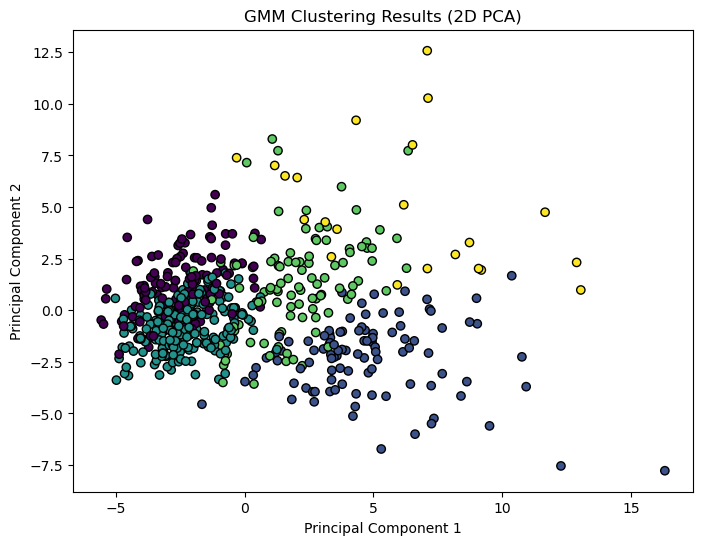

In [9]:
# pca
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# plot gmm
plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], 
            c=df_unlabeled["GMM_Cluster"], 
            cmap='viridis', marker='o', edgecolor='k')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("GMM Clustering Results (2D PCA)")
plt.show()


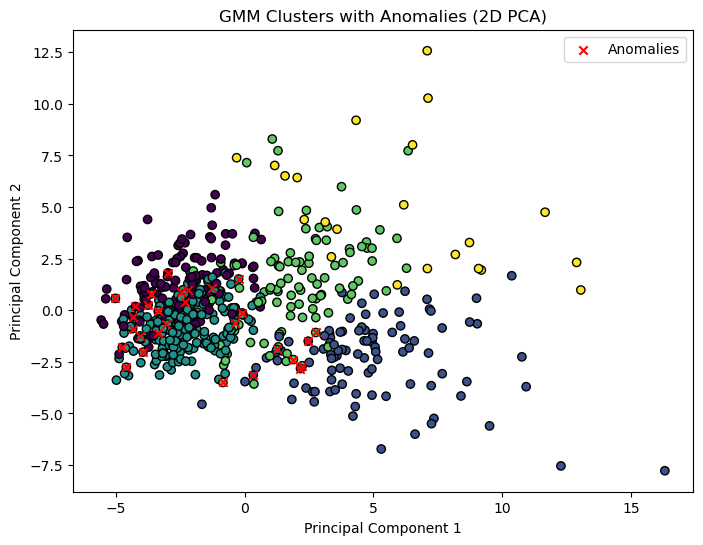

In [10]:
# plot gmm with anomalies
plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], 
            c=df_unlabeled["GMM_Cluster"], 
            cmap='viridis', marker='o', edgecolor='k')

# overlay anomalies
plt.scatter(df_pca[anomalies.index, 0], df_pca[anomalies.index, 1], 
            color='red', marker='x', label='Anomalies')

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("GMM Clusters with Anomalies (2D PCA)")
plt.legend()
plt.show()